In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_rez = os.path.join(path2p, "data")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
import graph_lib

%load_ext autoreload
%autoreload 2

Appended library directory /home/alyosha/work/git/mesoscopic-functional-connectivity/codes/lib


# Test 1. Random Matrix with increasing connectivity

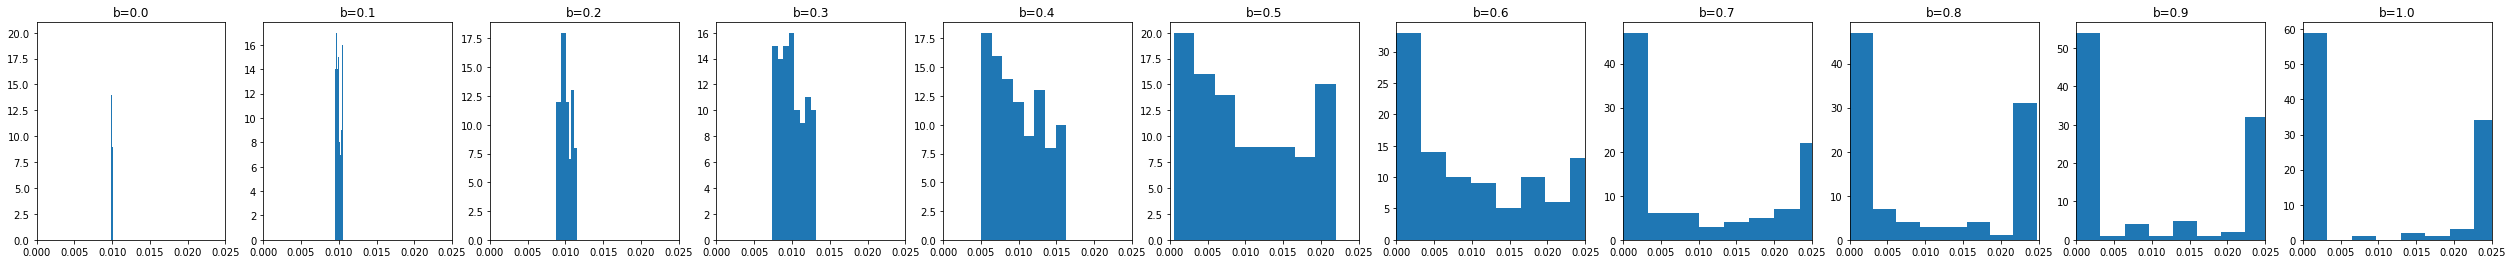

In [145]:
'''
Parameterized connection strength distribution with two parameters p,a
1) Mean connection strength is always 1
1) if a = 0, all connection strengths are equal
2) if a = 1, there is exactly Np connections with strength 0 and N(1-p) with strength 1/N(1-p)
'''
def skewdistr(N, s, b):
    pivot = int(N*s)
    a = 10**(3.0*b**0.6 - 3) / np.sqrt(N)
    dat = np.ones(N)/N
    dat[:pivot] -= np.random.uniform(0, a, pivot)
    dat[pivot:] += np.random.uniform(0, a, N-pivot)
    dat = np.clip(dat, 0.0, 1.0 / N / (1-s))
    return dat / np.sum(dat)

nPlot = 11
n = 100
s = 0.6

fig, ax = plt.subplots(ncols=nPlot, figsize=(11*4,4))
for iPlot in range(nPlot):
    b = iPlot/10
    d = skewdistr(n, s, b)
    ax[iPlot].hist(d, bins='auto')
    ax[iPlot].set_title("b="+str(b))
    ax[iPlot].set_xlim(0, 1.0 / n / (1-s))
plt.show()

In [149]:
def makemat(N, idx, val):
    M = np.zeros((N,N))
    M[idx] = val
    return M

# NxN matrix with approximately p random connections
randconn = lambda N,p: (np.random.uniform(0, 1, (N,N)) <= p).astype(int)

# NxN matrix where only the first L elements of the first row are filled
fill1row = lambda N,L: np.vstack((np.array([1]*L + [0]*(N-L)), np.zeros((N-1, N))))
fill1col = lambda N,L: fill1row(N, L).T

# Define skew distribution
skewdistr04 = lambda N, b: makemat(N, graph_lib.offdiag_idx(N), skewdistr(N*(N-1), 0.6, b))

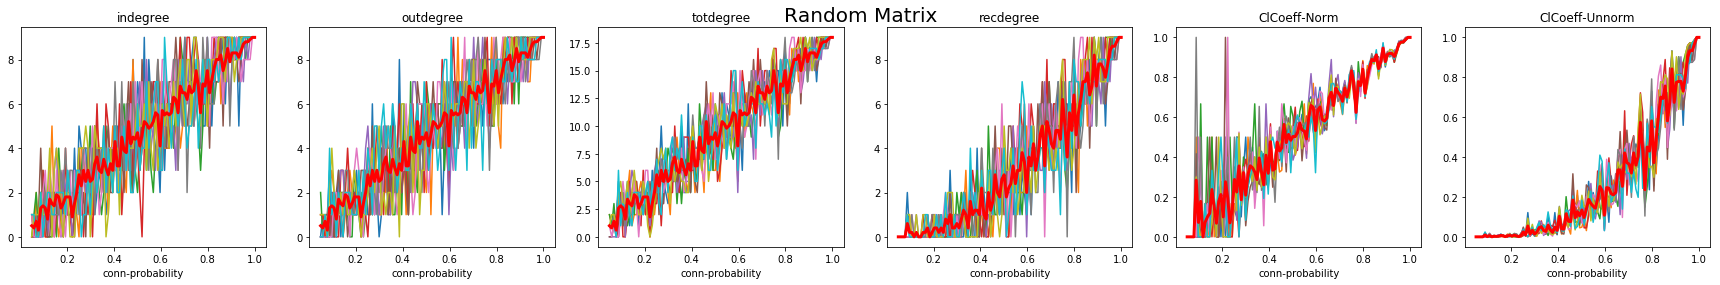

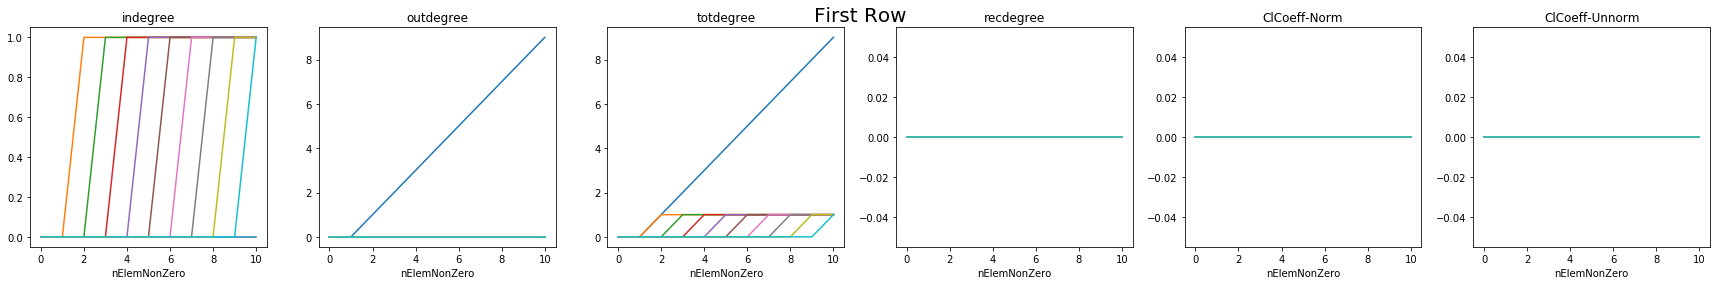

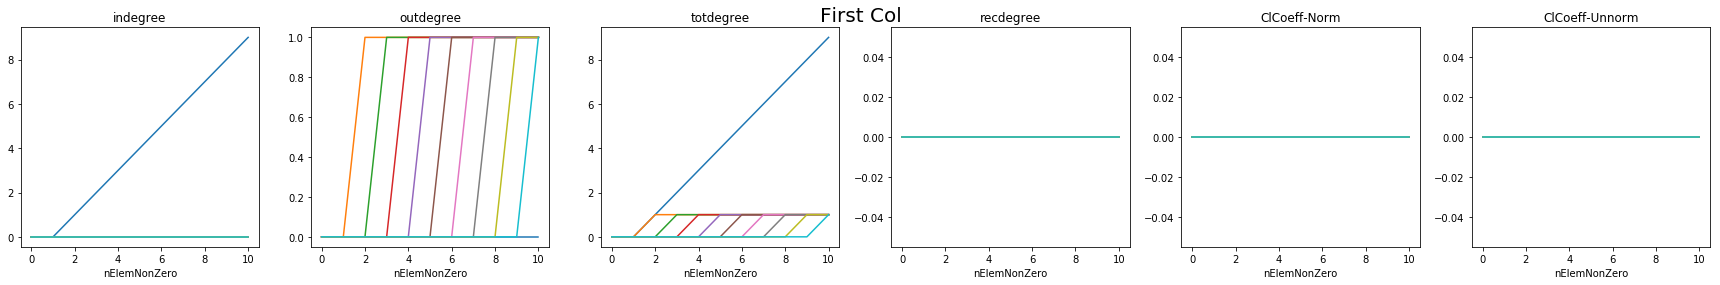

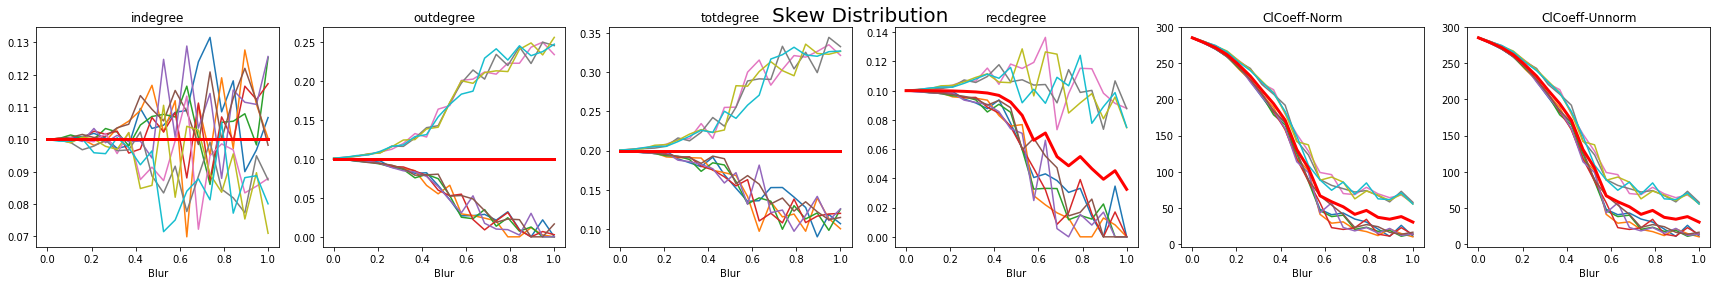

In [150]:
cl_coeff       = lambda M: graph_lib.cl_coeff(M, normDegree=True)
cl_coeffNoNorm = lambda M: graph_lib.cl_coeff(M, normDegree=False)

# Number of nodes in a matrix
nNode = 10

#############################
# List all tests to run
#############################
testFrame = pd.DataFrame({
    "Title"  : ["Random Matrix", "First Row", "First Col", "Skew Distribution"],
    "Func" : [randconn, fill1row, fill1col, skewdistr04],
    "PlotMean" : [True, False, False, True],
    "RangeName" : ["conn-probability", "nElemNonZero", "nElemNonZero", "Blur"],
    "Range" : [
        np.linspace(0.05, 1, 100),
        np.arange(0, nNode+1),
        np.arange(0, nNode+1),
        np.linspace(0, 1, 20),
    ]
})
nTest = len(testFrame["Title"])

#############################
# List all metrics to be evaluated
#############################
taskFrame = pd.DataFrame({
    "Name" : ['indegree', 'outdegree', 'totdegree', 'recdegree', 'ClCoeff-Norm', 'ClCoeff-Unnorm'],
    "Func" : [
        graph_lib.degree_in,
        graph_lib.degree_out,
        graph_lib.degree_tot,
        graph_lib.degree_rec,
        cl_coeff,
        cl_coeffNoNorm]})
nTask = len(taskFrame["Name"])

for iTest in range(nTest):
    testfunc  = testFrame["Func"][iTest]
    testrange = testFrame["Range"][iTest]
    testrangename = testFrame["RangeName"][iTest]
    testplotmean = testFrame["PlotMean"][iTest]
    
    #############################
    # Compute different metrics for random matrices
    #############################
    nTrial = len(testrange)
    data = np.zeros((nTask, nTrial, nNode))
    for iTrial in range(nTrial):
        M = testfunc(nNode, testrange[iTrial])
        for iTask in range(nTask):
            data[iTask, iTrial] = taskFrame["Func"][iTask](M)

    #############################
    # Plot these metrics
    #############################
    fig, ax = plt.subplots(ncols=nTask, figsize=(4*nTask, 4), tight_layout=True)
    fig.suptitle(testFrame["Title"][iTest], fontsize=20)
    for iTask in range(nTask):
        ax[iTask].set_xlabel(testrangename)
        ax[iTask].set_title(taskFrame["Name"][iTask])
        ax[iTask].plot(testrange, data[iTask])
        if testplotmean:
            ax[iTask].plot(testrange, np.mean(data[iTask], axis=1), 'r', linewidth=3)
    plt.show()